In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

In [42]:
import pandas as pd
import numpy as np
import geopandas as gpd
from quetzal.model import stepmodel
from quetzal.io import excel
from syspy.skims import skims
from scipy.optimize import minimize, differential_evolution
import matplotlib.pyplot as plt

In [3]:
model_path = '../model/' + scenario + '/'
input_path = '../input/'
output_path = '../output/'

In [4]:
# Load parameters for settings
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

# Calibration: inner/inter-zonal destination choice

## Requires MiD data

## Saves inner-zonal probabilities for zones

Assumptions apply as in `model_generation`

In [5]:
sm = stepmodel.read_json(model_path + 'de_zones')

In [6]:
# Transport demand segments
segments = [s.strip() for s in params['general']['demand_segments'].split(';')]
purposes = [s.split('_')[0] for s in segments][::2]

In [7]:
# Load trips from MiD2017
trips = pd.read_csv(input_path + 'transport_demand/calibration_all_trips_MiD2017.csv',
                    usecols=['purpose_model', 'purpose2', 'car_avail', 'distance',
                             'origin', 'destination', 'P_ID', 'W_GEW'])
trips.rename(columns={'car_avail': 'car_av'}, inplace=True)
trips = trips.loc[trips['car_av'].isin([0,1])]
trips.shape

(254861, 8)

In [8]:
# Drop return trips
trips = trips.loc[~trips['purpose2'].isin([8,9])]
len(trips)

153600

## Add choice attributes

In [9]:
# Add employment to trips
zone_dict = sm.zones['employment'].to_dict()
trips['employment'] = trips['origin'].map(zone_dict)

In [10]:
# Load other attraction POIs
pois = pd.read_csv(input_path + 'spatial_num_pois_raw.csv', index_col='index')
cats = pd.read_excel(input_path + 'spatial_OSM_POI_list.xlsx', sheet_name='categories')
cats['label'] = (cats['key'] + ' ' + cats['value'].fillna('')).str.strip()
for category, columns in cats.loc[cats['category'].notna()
                                 ].groupby('category').agg(
                                {'label': list})['label'].items():
    trips[category] = trips['origin'].map(pois[columns].sum(axis=1)).fillna(0)
    sm.zones[category] = sm.zones['FID'].map(pois[columns].sum(axis=1)).fillna(0)

In [11]:
# Drop "Leiningerland" as it does not have any OSM data
trips = trips.loc[trips['origin']!=73325007]
len(trips)

153546

In [12]:
# Put zone data in trips table (population, area, urbanisation)
trips = trips.merge(sm.zones[['population', 'area', 'urbanisation']],
                    how='inner', # drop trips outside of model zones
                    left_on='origin', right_index=True)
trips.shape

(153546, 21)

In [13]:
# Load inter-zonal composite cost from mode choice step
cc = pd.read_csv(output_path + scenario + '/mode_choice_od_composite_cost.csv')
cc.set_index(['origin', 'destination'], inplace=True)
# Rename segments to integer values
cc.columns = pd.MultiIndex.from_tuples(
    [(seg.split('_')[0], {'no': 0, 'car': 1}[seg.split('_')[1]])
     for seg in cc.columns],
    names=['purpose_model', 'car_av'])
# Reshape the table into a mergable format
cc = cc.unstack('destination').stack('purpose_model').stack('car_av')

In [14]:
# Get zones within a given distance for each origin
distances = skims.euclidean(sm.zones, coordinates_unit=sm.coordinates_unit, intrazonal=False)
nearby_zones = distances.set_index(['origin', 'destination']).groupby(level='origin')\
    ['euclidean_distance'].apply(lambda d: set(d.loc[d<50000].index.get_level_values('destination')))
cc_dests = cc.xs(0, level='car_av').xs('leisure', level='purpose_model')\
           .stack('destination').reset_index(level='destination').groupby(level='origin')\
           ['destination'].apply(set)

In [15]:
# Compute the mean CC to all destinations within a certain distance as accessibility
cc = cc.apply(lambda z: z[list(nearby_zones[z.name[0]].intersection(cc_dests[z.name[0]]))].mean(), axis=1)
cc = cc.rename('acc').to_frame()

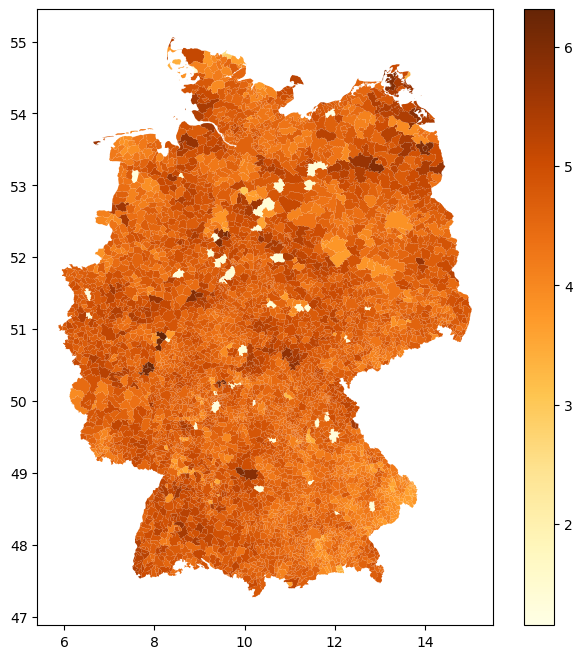

In [16]:
zones = gpd.GeoDataFrame(sm.zones, crs=sm.epsg)
zones['acc'] = cc.xs(1, level='car_av').groupby(level='origin')['acc'].mean()
zones.plot(column='acc', cmap='YlOrBr', figsize=(8,8), legend=True)
corrupted_acc_zones = zones.loc[zones['acc']<2].index

In [17]:
# Drop accessibility outliers that do not fit a pattern
trips = trips.loc[~trips['origin'].isin(corrupted_acc_zones)]
len(trips)

153173

In [18]:
# Merge
trips['acc'] = trips.set_index(['origin', 'purpose_model', 'car_av']).index.map(cc['acc'])
trips.loc[trips['origin']==trips['destination'], 'acc'] = np.nan
for p in purposes:
    for car in [0,1]:
        mask = (trips['purpose_model']==p) & (trips['car_av']==car)
        trips.loc[mask, 'acc'] = trips.loc[mask, 'acc'].fillna(trips.loc[mask, 'acc'].max())

In [19]:
trips = trips.loc[trips.notna().all(axis=1)]
trips.shape

(153173, 22)

In [20]:
# Define a choice variable
trips['choice'] = (trips['origin']!=trips['destination']).astype(int)

In [21]:
# Probabilities of making an inner-zonal trip
np.round(1 - trips.groupby(['purpose_model', 'car_av']).apply(
    lambda df: (df['choice'] * df['W_GEW']).mean()), 3)*100

purpose_model  car_av
accompany      0         63.5
               1         64.2
business       0         65.5
               1         62.0
buy/execute    0         68.6
               1         68.0
commuting      0         55.1
               1         49.9
education      0         47.6
               1         61.5
leisure        0         54.2
               1         60.9
dtype: float64

## Build a choice model

The model is segmented in
* population segments: car availability in household
* trip purposes

The utility formulation for the choice between making a trip within the home zone or to another one is:

$V^{inner}_i= log(\sum_{j\in A} a_{i,j}) \beta^{ATTR}_i + log(\text{POP} / \text{AREA}) \beta^{POP}_i$

$V^{inter}_i=ASC^{inter}_i + ACC \beta^{ACC}_i$

Attraction attributes $a$ are chosen for each demand segment $i$ based on their relevance

Final LL for commuting_no_car (N=1716): -58.0 (CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH)
Final LL for commuting_car (N=28063): -75.0 (CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH)
Final LL for business_no_car (N=347): -42.0 (CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH)
Final LL for business_car (N=6247): -70.0 (CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH)
Final LL for education_no_car (N=372): -40.0 (CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH)
Final LL for education_car (N=6786): -87.0 (CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH)
Final LL for buy/execute_no_car (N=2413): -120.0 (CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH)
Final LL for buy/execute_car (N=51732): -193.0 (CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH)
Final LL for leisure_no_car (N=2391): -35.0 (CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH)
Final LL for leisure_car (N=38707): -48.0 (CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH)
Final LL for accompany_no_car (N=253): -15.0 (CONVERGE

Text(0.5, 0.98, 'Probability of inner-zonal trips')

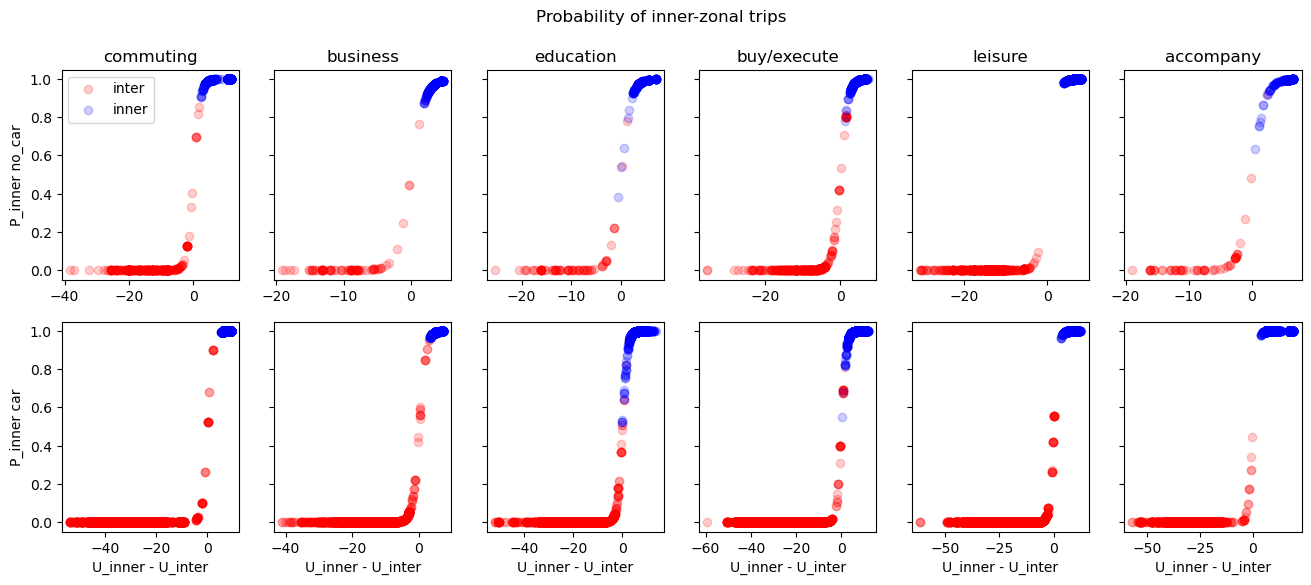

In [70]:
# Results container
betas = pd.DataFrame(index=['ASC0', 'b_pop0', 'b_area0', 'b_attr0', 'b_acc0', 'ASC1', 'b_pop1', 'b_area1', 'b_attr1', 'b_acc1'],
                     columns=segments)

# POI categories for utility functions in order of purposes
purpose_categories = [
    ['employment'], ['employment'], ['childcare', 'school', 'higher_education'],
    ['shop', 'medical', 'special_shop'],
    ['daily_leisure', 'occasional_leisure', 'holiday'],
    ['school', 'medical', 'childcare']
]
fig, ax = plt.subplots(nrows=2, ncols=len(purposes), figsize=(16,6), sharey='all')
for i,p,poi_cats in zip(range(len(purposes)), purposes, purpose_categories):
    for car, car_name in zip([0,1], ['_no_car', '_car']):
        
        # Utility formulation
        data = trips.loc[(trips['car_av']==car) & (trips['purpose_model']==p)].copy()
        data['pop'] = np.log((1 + data['population']))
        data['area'] = data['area'] / 100
        data['attr'] = np.log(1 + data[poi_cats].sum(axis=1))
        #data['acc'] = np.log(data['acc'])
        # Design matrices for the choices
        X0 = np.column_stack([np.zeros(len(data)), data['pop'], data['area'], data['attr'], data['acc']])  # Choice 0
        X1 = np.column_stack([np.ones(len(data)), data['pop'], data['area'], data['attr'], data['acc']])  # Choice 1
        y = data['choice'].values
        weights = data['W_GEW'].values
        
        # Define the log-likelihood function
        def log_likelihood(params, X0, X1, y, weights):
            # Utility functions
            U0 = np.dot(X0, params[:X0.shape[1]])
            U1 = np.dot(X1, params[X0.shape[1]:])
            # Choice probabilities
            P0 = np.exp(U0) / (np.exp(U0) + np.exp(U1))
            P1 = np.exp(U1) / (np.exp(U0) + np.exp(U1))
            # Add a small epsilon to probabilities to avoid log(0)
            epsilon = 1e-10
            P0 = np.clip(P0, epsilon, 1 - epsilon)
            P1 = np.clip(P1, epsilon, 1 - epsilon)
            # Log-likelihood
            ll = np.sum((y * np.log(P1) + (1 - y) * np.log(P0)) * weights)
            return -ll  # Negative because we will minimize
        
        # Optimize the log-likelihood function
        initial_params = [0., 0., 0., -1., 1.] + [0., 0., 0., 1., -1.]
        bounds = [(-0,0), (-10,10), (-10,10), (0, 10), (0,100)] + [(-100,100), (-10,10), (-10,10), (-10, 0), (-100,0)]
        result = minimize(log_likelihood, initial_params, args=(X0, X1, y, weights), method='L-BFGS-B', bounds=bounds)
        #result = minimize(log_likelihood, initial_params, args=(X0, X1, y, weights), method='BFGS')
        #result = differential_evolution(log_likelihood, bounds, args=(X0, X1, y, weights), strategy='best1bin', maxiter=10000)
        
        # Output the results
        betas[p+car_name] = result.x
        final_ll = -log_likelihood(betas[p+car_name], X0, X1, y, weights)
        print("Final LL for {} (N={}): {} ({})".format(
            p+car_name, len(data), np.round(final_ll,0), result.message))
        
        # Plot
        U0 = np.dot(X0, result.x[:X0.shape[1]])
        U1 = np.dot(X1, result.x[X0.shape[1]:])
        P0 = np.exp(U0) / (np.exp(U0) + np.exp(U1))
        y = data['choice'].astype(bool)
        ax[car,i].scatter((U0-U1)[y], P0[y], c='red', alpha=.2, label='inter')
        ax[car,i].scatter((U0-U1)[~y], P0[~y], c='blue', alpha=.2, label='inner')
        ax[car,0].set_ylabel('P_inner ' + car_name[1:])
    ax[0,i].set_title(p)
    ax[1,i].set_xlabel('U_inner - U_inter')
ax[0,0].legend()
fig.suptitle('Probability of inner-zonal trips')

In [71]:
np.round(betas, 2)

,commuting_no_car,commuting_car,business_no_car,business_car,education_no_car,education_car,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car
ASC0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
b_pop0,-1.03,0.12,0.11,-0.24,-2.10,-3.50,-1.13,-1.50,0.29,-1.09,-0.76,-0.99
b_area0,0.75,0.11,0.08,0.20,0.21,0.19,0.21,-0.10,0.02,0.08,-0.10,0.72
b_attr0,0.35,0.00,0.00,0.18,2.28,3.21,1.12,1.69,0.00,1.24,1.28,1.01
b_acc0,17.34,5.51,7.85,12.23,10.76,14.93,9.84,10.37,9.19,13.28,3.99,6.36
ASC1,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
b_pop1,1.03,-0.12,-0.11,0.24,2.10,3.50,1.13,1.50,-0.29,1.09,0.76,0.99
b_area1,-0.75,-0.11,-0.08,-0.20,-0.21,-0.19,-0.21,0.10,-0.02,-0.08,0.09,-0.72
b_attr1,-0.35,0.00,0.00,-0.18,-2.28,-3.21,-1.12,-1.69,0.00,-1.24,-1.28,-1.01
b_acc1,-17.34,-5.51,-7.85,-12.23,-10.76,-14.93,-9.84,-10.37,-9.19,-13.28,-3.99,-6.36


In [72]:
# Save results
betas.to_csv(input_path + 'estimation_results_inner-inter_betas.csv')